# 📜 Visualiza dos dados entre videos do Youtube e os stocks de grandes empresas 📜 

## Importar Bibliotecas

In [1]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext
from datetime import datetime
from functools import reduce
from pyspark.sql.functions import sum
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt

## Criação do Spark para ser utilizado em PySpark

In [2]:
spark_ = SparkSession.builder \
    .appName("Data Integration") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

## Importanção dos dados das duas coleções já filtradas

Estes dados vem filtrados dos dados de cada empresa feitas no jupyter do tratamento de dados. Sao duas coleções, uma com os dados de stocks de todas as empresa e outro com os dados de videos de todas as empresas

In [3]:
df_youtube = spark_.read.format("mongo") \
    .option("uri", "mongodb://mongodb:27017/Final_Database.youtube").load()

df_company = spark_.read.format("mongo") \
    .option("uri", "mongodb://mongodb:27017/Final_Database.company").load()


In [4]:
companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony'] #quando necessitamos de saber quantas empresas existem

## Visualização dos dados em termos de Views e stocks por data em cada empresa

O objetivo inicial é criar diversos gráficos lineares que ilustrem o comportamento dos stocks ao longo dos dias, considerando as views de todos os vídeos no YouTube relacionados às empresas em análise.

Entre as colunas disponíveis nos dados, a métrica que apresenta a maior possibilidade de comparação, capaz de ajudar a explicar a subida ou descida dos stocks, são as views. Até porque as demais colunas não apresentam uma correlação evidente ou significativa para justificar determinadas variações. Com isto em mente, formulamos varios graficos com focos nessas duas variaveis.

## Visualização dos dados em termos de Views por dia em cada empresa

O primeiro gráfico foca-se nas views diárias de cada empresa no YouTube. Devido à grande quantidade de vídeos relacionados à empresa "Sony", as demais empresas aparecem representadas de forma menos expressiva. Com isto, podemos perceber que a  Sony investe mais em publicidade (seja diretamente ou por meio de terceiros) nas redes sociais, neste caso, como analisado, no YouTube. Por outro lado, as outras empresas parecem utilizar o YouTube de forma mais pontual, seja para compartilhar informações sobre avanços internos e novos produtos, seja devido à menor quantidade de vídeos de terceiros que mencionam essas empresas.

É importante considerar a possível ausência de alguns vídeos nos dados disponíveis, o que significa que as observações atuais podem não refletir completamente a realidade.

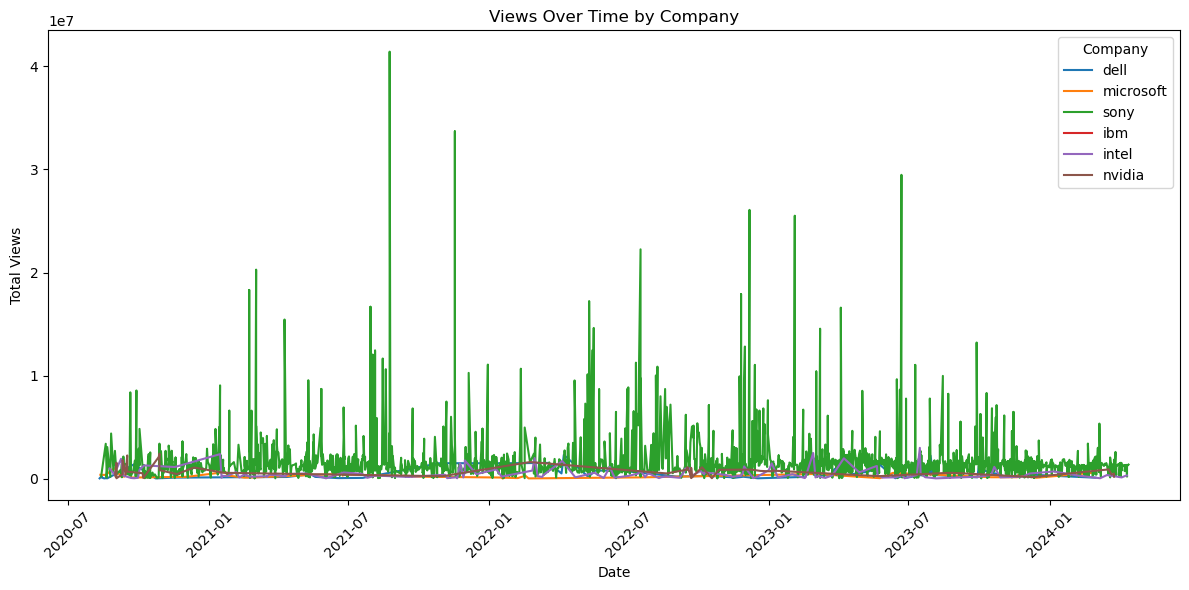

In [5]:
df_views_over_time = df_youtube.withColumn("published_date", to_date(col("publishedAt"))).groupBy(
    "published_date", "company", "title", "view_count"
).agg(
    sum("view_count").alias("total_views")
).orderBy("published_date")

colors = plt.colormaps['tab10']
plot_data_yt = df_views_over_time.toPandas() 
plt.figure(figsize=(12, 6))
companies = plot_data_yt["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt[plot_data_yt["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )
plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
plot_data_yt = df_views_over_time.toPandas() 

In [7]:
plot_data_companies = df_company.toPandas()

## Visualização dos dados em termos de Stocks em cada empresa

Em seguida, analisamos o comportamento dos stocks de cada empresa ao longo dos anos. É importante destacar que algumas empresas possuem dados disponíveis apenas para períodos específicos. Por exemplo, os registros para a NVIDIA começam só em 2000

No gráfico, é possível observar que empresas como a NVIDIA e a Microsoft apresentam preços de stocks significativamente elevados. Por outro lado, as demais empresas demonstram um comportamento mais estável, sem grandes picos de valorização em seus preços de stocks. 

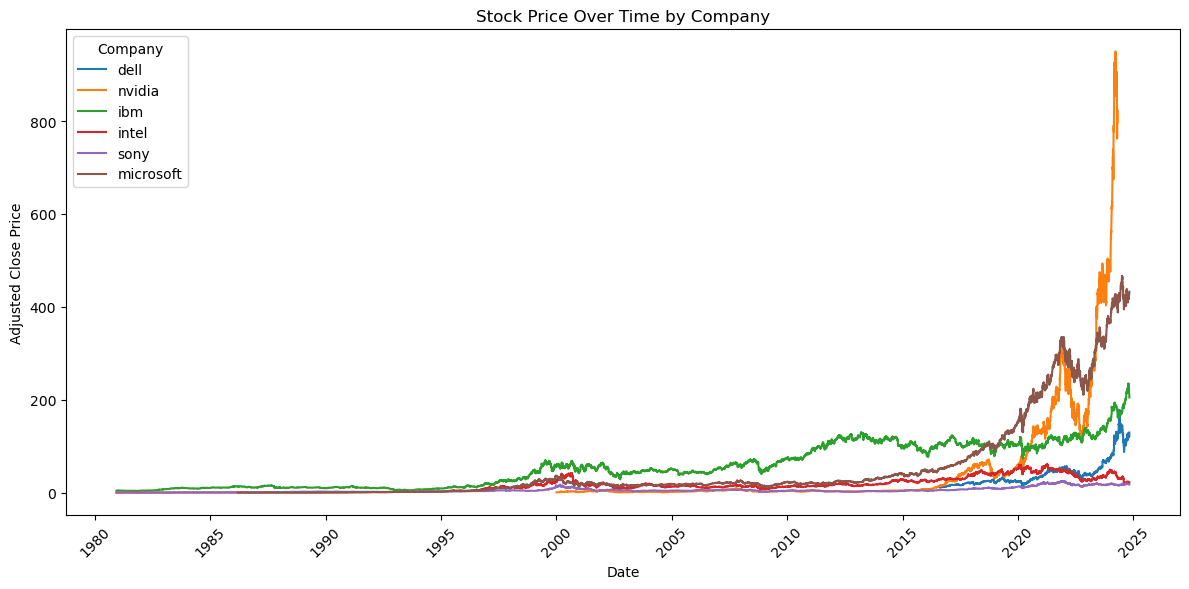

In [8]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.colormaps['tab10']
for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Para facilitar a análise em um intervalo em que todas as empresas possuem dados disponíveis simultaneamente, realizamos um estudo para identificar essas datas em comum. A partir dessa análise, geramos um gráfico que ilustra esse intervalo de tempo, permitindo observar de forma clara o período em que os dados estão disponíveis para todas as empresas de forma consistente.

Essa abordagem é essencial para evitar interpretações enviesadas ou inconsistências nos resultados, garantindo que as comparações entre as empresas sejam realizadas com base em um período comum de dados.

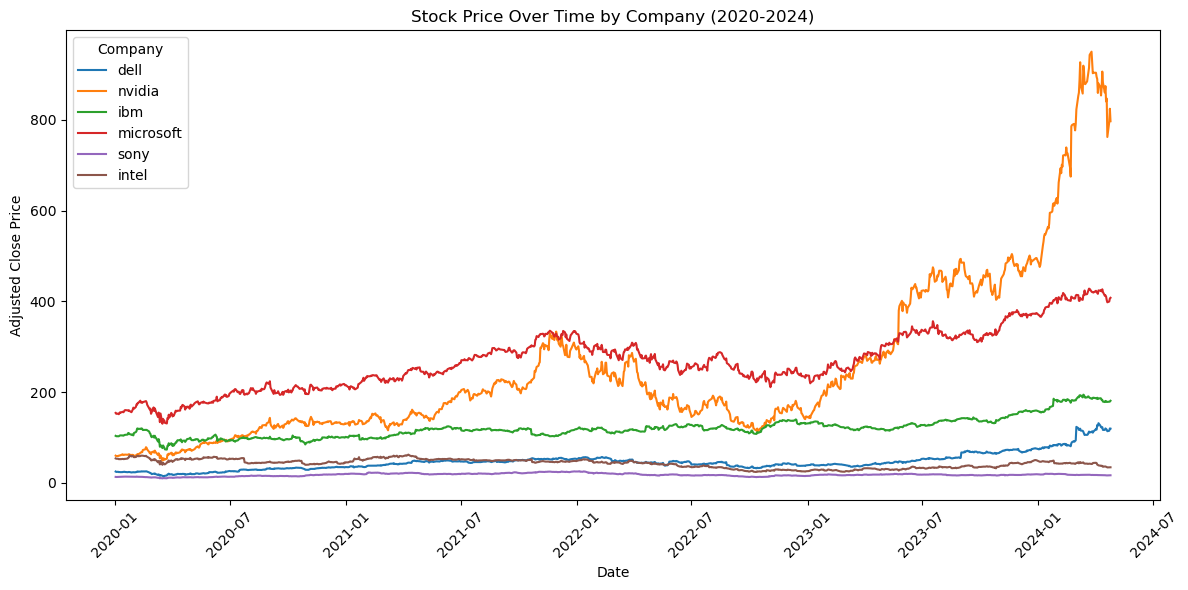

In [9]:
plot_data_filtered = df_company.filter(
    (col("Date") >= "2020-01-01") & (col("Date") <= "2024-04-24")
)

plot_data_companies = plot_data_filtered.toPandas()
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.colormaps['tab10']

for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Escolha de Empresa a Analisar

De seguida, queremos comparar os gráficos de views e stocks para cada empresa. Para isso, foi necessário criar um novo conjunto de dados com a única empresa a ser pesquisada. Caso queiramos comparar com outras empresas, basta acrescentá-las no código.

Exemplo:

```python
plot_data_yt_company = plot_data_yt[
    (plot_data_yt["company_name"] == "sony") |
    (plot_data_yt["company_name"] == "nvidia")
]

In [10]:
plot_data_yt_company = plot_data_yt[(plot_data_yt["company"] == "sony")]

In [11]:
#plot_data_yt_company

In [12]:
plot_data_companies_company = plot_data_companies[(plot_data_companies["company_name"] == "sony")]

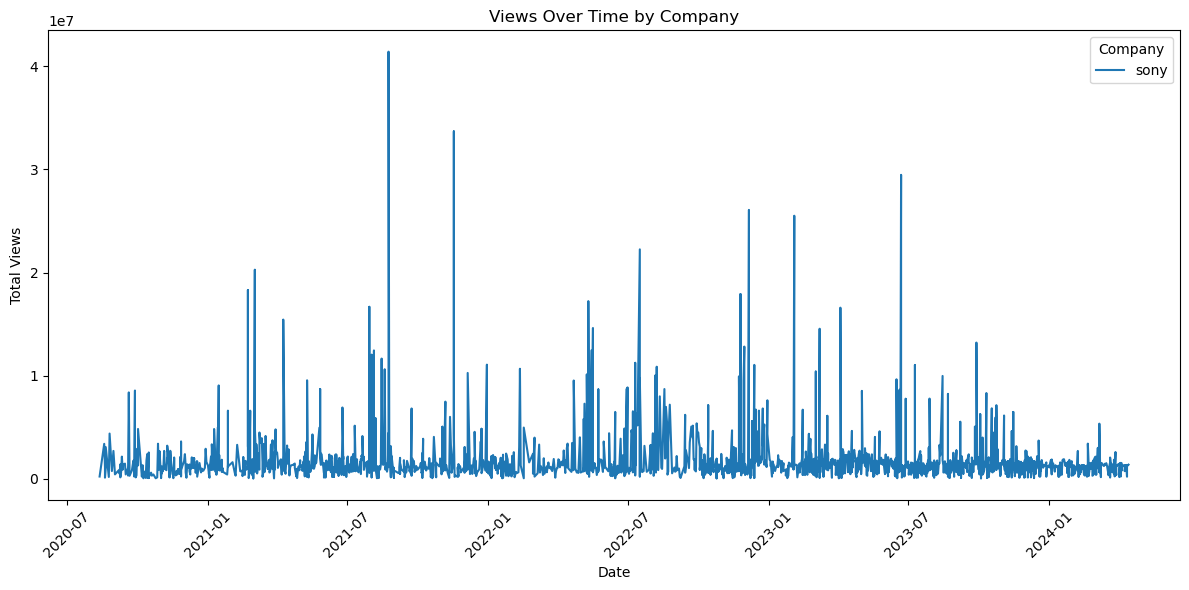

In [13]:
plt.figure(figsize=(12, 6))
companies = plot_data_yt_company["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt_company[plot_data_yt_company["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )
plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

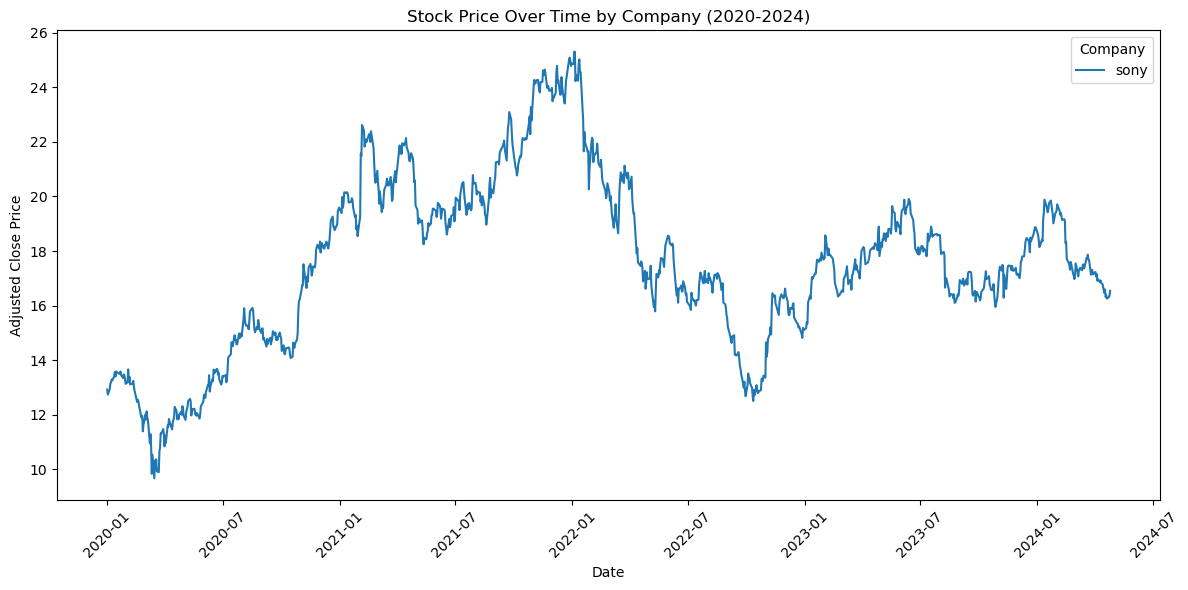

In [14]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies_company["company_name"].unique()
colors = plt.colormaps['tab10']
for i, company in enumerate(companies):
    company_data = plot_data_companies_company[plot_data_companies_company["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))
plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())
#decidimos normalizar de forma a pudermos analisar mais facilmente os dados (como os dados tem tamanhos muitos dispersos, a analise so é possivel a partir dos mesmos normalizados)

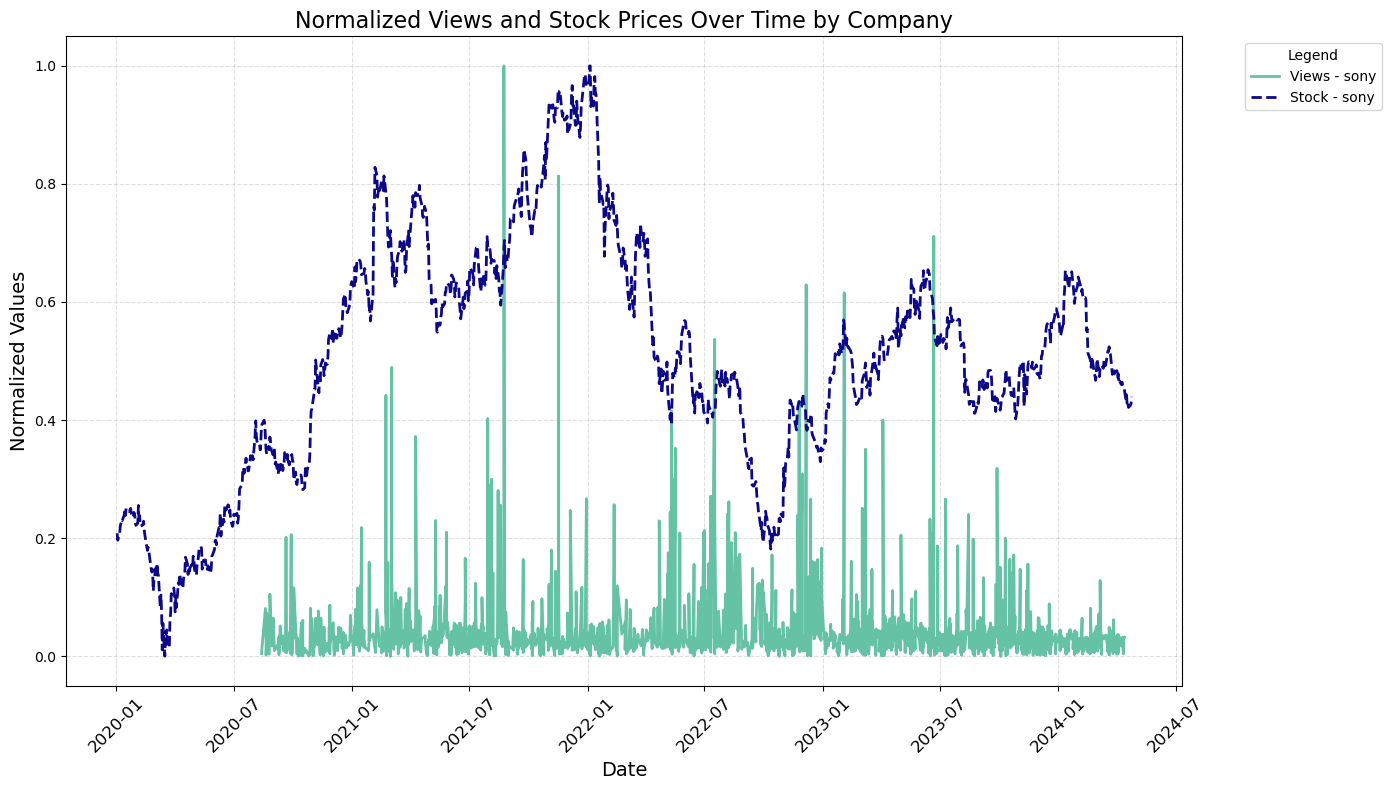

In [18]:
if 'published_date' not in plot_data_yt_company.columns:
    plot_data_yt_company['published_date'] = pd.to_datetime(plot_data_yt_company['published_date'], errors='coerce')

plot_data_yt_company = plot_data_yt_company.copy()
plot_data_companies_company = plot_data_companies_company.copy()

plot_data_yt_company.loc[:, "normalized_views"] = normalize(plot_data_yt_company["total_views"])
plot_data_companies_company.loc[:, "normalized_stocks"] = normalize(plot_data_companies_company["Adj Close"])

colors = plt.colormaps['tab10']


colors_views = plt.colormaps['Set2']
colors_stocks = plt.colormaps['plasma']


plt.figure(figsize=(14, 8))
for i, company in enumerate(plot_data_yt_company["company"].unique()):
    company_data = plot_data_yt_company[plot_data_yt_company["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["normalized_views"],
        label=f"Views - {company}",
        color=colors_views(i),
        linestyle='-',  
        linewidth=2
    )
for i, company in enumerate(plot_data_companies_company["company_name"].unique()):
    company_data = plot_data_companies_company[plot_data_companies_company["company_name"] == company]
    plt.plot(
        company_data["Date"],
        company_data["normalized_stocks"],
        label=f"Stock - {company}",
        color=colors_stocks(i),
        linestyle='--',  
        linewidth=2
    )
plt.title("Normalized Views and Stock Prices Over Time by Company", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Normalized Values", fontsize=14)
plt.legend(title="Legend", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

In [17]:
top_5_microsoft = plot_data_yt[plot_data_yt["company"] == "microsoft"].nlargest(5, "view_count")
top_5_nvidia = plot_data_yt[plot_data_yt["company"] == "nvidia"].nlargest(5, "view_count")

print("Top 5 vídeos da Microsoft:")
print(top_5_microsoft[["title", "view_count", "published_date"]])
print("\nTop 5 vídeos da NVIDIA:")
print(top_5_nvidia[["title", "view_count", "published_date"]])

Top 5 vídeos da Microsoft:
                                                 title  view_count  \
20                 Microsoft Surface Duo Unboxing. Wow     1023918   
49   Microsoft Duo Durability Test! - How Thin is t...      999171   
833        How Microsoft buys out every gaming company      803071   
492  Windows 11: Microsoft CEO Satya Nadella on the...      698557   
240         Microsoft Surface Pro 7: The Better Choice      645842   

    published_date  
20      2020-08-30  
49      2020-09-18  
833     2022-01-19  
492     2021-06-24  
240     2021-01-22  

Top 5 vídeos da NVIDIA:
                                                 title  view_count  \
103  Nvidia tried to bury this… Radeon 6000 (RIP RT...     2420048   
46                               Nvidia, you PROMISED!     2251723   
101     I'm DONE covering for NVIDIA - RTX 3070 Review     2092793   
37   We finally have our hands on the NVIDIA RTX 3080!     1799066   
883                     NVIDIA REFUSED To Send Us T